
# Offer Engagement Prediction

## 1. Business Objective (The "Why")
In a high-volume e-commerce environment, users are bombarded with offers. Indiscriminate targeting leads to:
*   **User Fatigue**: Users ignore notifications or churn.
*   **Wasted Budget**: Incentives are given to users who wouldn't convert or aren't interested.
*   **Missed Revenue**: High-intent users miss relevant offers buried in noise.

**The Goal**: Move from "Broadcast" to "Precision" targeting. We aim to build an AI model that predicts the **exact probability** (`0.0` to `1.0`) that a specific user will click on a specific offer.

## 2. Technical Approach (The "How")
To solve this, we treat the problem as a **Binary Classification** task (`is_clicked` = 1 vs 0).

*   **Session-Awareness**: We don't just look at "who the user is" (demographics), but "what they are doing right now". We link **Retail** behavior (browsing items) with **Offer** impressions in real-time.
*   **Point-in-Time Correctness**: We strictly observe the timeline. We only use information available *before* the offer was shown to prevent data leakage.
*   **Gradient Boosting**: We use **LightGBM**, a state-of-the-art algorithm for tabular data, optimized for speed and accuracy on large datasets.

## 3. Success Metrics
We will evaluate the model not just on accuracy, but on **Business Impact**:
*   **Lift at Top 10%**: If we only target the top 10% of users ranked by the model, how many clicks do we capture compared to random guessing?
*   **Calibration (Log Loss)**: Are the predicted probabilities real? (e.g., if we predict 20% risk, does it happen 20% of the time?)


In [1]:

# Install dependencies if needed (uncomment for Colab)
# !pip install lightgbm shap polars

import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import log_loss, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# ============================================================
# COLAB FREE OPTIMIZATION: Memory & GPU Setup
# ============================================================

# Force garbage collection helper
def clear_memory():
    """Aggressively clear memory for Colab Free tier."""
    gc.collect()

# Check if running on Colab with GPU
try:
    import google.colab
    IN_COLAB = True
    # Check for GPU
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    HAS_GPU = result.returncode == 0
    if HAS_GPU:
        print("[OK] Running on Colab with GPU")
    else:
        print("[WARN] Running on Colab CPU-only")
except ImportError:
    IN_COLAB = False
    HAS_GPU = False
    print("[INFO] Running locally")

# Configuration
CLEANED_DATA_DIR = "cleaned_data"
OUTPUT_DIR = "models/offer_ctr_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SEED = 42

# COLAB FREE: Limit dataframe display to save memory
pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


[INFO] Running locally


In [2]:

def optimize_dtypes(df):
    """
    COLAB FREE OPTIMIZATION: Reduce memory by downcasting types.
    Can reduce memory by 50-70% for large dataframes.
    """
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'int64':
            # Downcast integers
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'float64':
            # Downcast floats
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'object':
            # Convert object to category if low cardinality
            if df[col].nunique() / len(df) < 0.5:
                df[col] = df[col].astype('category')
    
    return df

def load_data():
    """Load and optimize datasets for Colab Free memory constraints."""
    print("Loading datasets...")
    
    # Load Users (small dataset)
    users = pd.read_parquet(os.path.join(CLEANED_DATA_DIR, 'users_clean.parquet'))
    users = optimize_dtypes(users)
    print(f"Users: {len(users):,} ({users.memory_usage(deep=True).sum() / 1e6:.1f} MB)")
    
    # Load Retail Events (Context) - only needed columns
    retail_cols = ['user_id', 'timestamp', 'item_id', 'subdomain']
    retail_events = pd.read_parquet(
        os.path.join(CLEANED_DATA_DIR, 'retail_events_clean.parquet'),
        columns=retail_cols  # OPTIMIZATION: Load only needed columns
    )
    retail_events = retail_events.sort_values('timestamp')
    retail_events = optimize_dtypes(retail_events)
    print(f"Retail Events: {len(retail_events):,} ({retail_events.memory_usage(deep=True).sum() / 1e6:.1f} MB)")
    
    # Load Offers Events (Target)
    offers_events = pd.read_parquet(os.path.join(CLEANED_DATA_DIR, 'offers_events_clean.parquet'))
    offers_events = offers_events.sort_values('timestamp')
    offers_events = optimize_dtypes(offers_events)
    print(f"Offers Events: {len(offers_events):,} ({offers_events.memory_usage(deep=True).sum() / 1e6:.1f} MB)")
    
    # Total memory
    total_mb = (users.memory_usage(deep=True).sum() + 
                retail_events.memory_usage(deep=True).sum() + 
                offers_events.memory_usage(deep=True).sum()) / 1e6
    print(f"\n[INFO] Total Memory: {total_mb:.1f} MB")
    
    return users, retail_events, offers_events

users, retail_events, offers_events = load_data()
clear_memory()


Loading datasets...
Users: 3,500,000 (56.0 MB)
Retail Events: 4,128,330 (126.9 MB)
Offers Events: 30,475,441 (823.1 MB)

[INFO] Total Memory: 1006.0 MB


In [3]:

def define_target(df):
    print("Defining Target Variable...")
    # We define 'Engagement' as an explicit CLICK or CONVERSION.
    # Positive (1): 'redirect_to_partner', 'like' (Actual Clicks)
    # Negative (0): 'seen', 'offer_shown' (Impressions/Views without click)
    
    # NOTE: We exclude 'offer_shown' from positive class because it is just an impression.
    # We want to predict who will actually CLICK.
    
    positive_actions = ['redirect_to_partner', 'like']
    df['is_clicked'] = df['action_type'].isin(positive_actions).astype(int)
    
    ctr = df['is_clicked'].mean()
    print(f"Global CTR (Strict Click-Through): {ctr:.2%}")
    return df

offers_events = define_target(offers_events)


Defining Target Variable...
Global CTR (Strict Click-Through): 0.49%


In [4]:

def build_features(offers, retail, users):
    """
    Build features for CTR prediction.
    
    Features:
    - Temporal: hour, day_of_week
    - Item: item_id (categorical), offer_popularity
    - User History: user_hist_ctr (expanding mean of past clicks)
    - Retail Context: seconds_since_retail, has_retail_activity, last_retail_subdomain
    - Demographics: socdem_cluster, region
    
    COLAB FREE: Optimized for memory efficiency.
    """
    print("Building Features...")
    
    # Work with a copy to avoid modifying original
    offers = offers.copy()
    
    # 1. Temporal Features
    print("  Computing Temporal Features...")
    offers['hour'] = (offers['timestamp'].dt.seconds // 3600).astype('int8')  # int8 saves memory
    offers['day_of_week'] = (offers['timestamp'].dt.days % 7).astype('int8')
    
    # 2. Item Features
    print("  Encoding Offer IDs...")
    offers['item_id'] = offers['item_id'].astype('category')
    
    # Offer Popularity (Expanding Count) - memory efficient version
    print("  Computing Offer Popularity...")
    offers['offer_popularity'] = offers.groupby('item_id').cumcount() + 1
    offers['offer_popularity'] = offers['offer_popularity'].astype('int32')
    
    # 3. Historical CTR (Expanding Mean)
    print("  Computing Historical CTR...")
    offers['user_hist_ctr'] = offers.groupby('user_id')['is_clicked'].transform(
        lambda x: x.shift().expanding().mean()
    ).fillna(0).astype('float32')  # float32 saves memory
    
    clear_memory()
    
    # 4. Retail Context (Merge Asof)
    # FIX: Rename the retail timestamp BEFORE merge to avoid column conflicts
    print("  Merging Retail Context (asof)...")
    retail_sorted = retail.sort_values('timestamp').copy()
    retail_sorted = retail_sorted.rename(columns={'timestamp': 'retail_timestamp'})
    offers_sorted = offers.sort_values('timestamp')
    
    # COLAB FREE: Process in chunks if dataset is large
    if len(offers_sorted) > 1_000_000:
        print("    Large dataset detected, processing in chunks...")
        chunk_size = 500_000
        chunks = []
        for start in range(0, len(offers_sorted), chunk_size):
            chunk = offers_sorted.iloc[start:start+chunk_size]
            merged_chunk = pd.merge_asof(
                chunk,
                retail_sorted[['user_id', 'retail_timestamp', 'subdomain']],
                left_on='timestamp',
                right_on='retail_timestamp',
                by='user_id',
                direction='backward'
            )
            chunks.append(merged_chunk)
            clear_memory()
        merged = pd.concat(chunks, ignore_index=True)
        del chunks
    else:
        merged = pd.merge_asof(
            offers_sorted,
            retail_sorted[['user_id', 'retail_timestamp', 'subdomain']],
            left_on='timestamp',
            right_on='retail_timestamp',
            by='user_id',
            direction='backward'
        )
    
    del retail_sorted, offers_sorted
    clear_memory()
    
    # Feature: How recently did they interact with retail?
    merged['seconds_since_retail'] = (merged['timestamp'] - merged['retail_timestamp']).dt.total_seconds()
    merged['seconds_since_retail'] = merged['seconds_since_retail'].fillna(-1).astype('float32')
    merged['has_retail_activity'] = (merged['seconds_since_retail'] != -1).astype('int8')
    
    # Clean up temporary column
    if 'retail_timestamp' in merged.columns:
        merged = merged.drop(columns=['retail_timestamp'])
    
    # Feature: What category did they see last?
    # FIX: Handle categorical column - convert to codes first, fillna with -1 for missing
    if merged['subdomain'].dtype.name == 'category':
        # Add 'none' category if not present, or use -1 for missing
        merged['last_retail_subdomain'] = merged['subdomain'].cat.codes.astype('int16')
        # cat.codes returns -1 for NaN, which is what we want
    else:
        merged['last_retail_subdomain'] = merged['subdomain'].fillna('none')
        merged['last_retail_subdomain'] = merged['last_retail_subdomain'].astype('category').cat.codes.astype('int16')
    
    # Drop subdomain if it exists (not needed anymore)
    if 'subdomain' in merged.columns:
        merged = merged.drop(columns=['subdomain'])
    
    clear_memory()
    
    # 5. Demographics
    print("  Merging Demographics...")
    final_df = merged.merge(users[['user_id', 'socdem_cluster', 'region']], on='user_id', how='left')
    final_df['socdem_cluster'] = final_df['socdem_cluster'].fillna(-1).astype('int16')
    final_df['region'] = final_df['region'].fillna(-1).astype('int16')
    
    del merged
    clear_memory()
    
    print(f"  [OK] Final dataset: {final_df.shape[0]:,} rows, {final_df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
    return final_df

full_dataset = build_features(offers_events, retail_events, users)

# Garbage Collection - free source data
del offers_events, retail_events
clear_memory()


Building Features...
  Computing Temporal Features...
  Encoding Offer IDs...
  Computing Offer Popularity...


C:\Users\brian\AppData\Local\Temp\ipykernel_5296\2885889374.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offers['offer_popularity'] = offers.groupby('item_id').cumcount() + 1


  Computing Historical CTR...
  Merging Retail Context (asof)...
    Large dataset detected, processing in chunks...
  Merging Demographics...
  [OK] Final dataset: 30,475,441 rows, 1463.1 MB


In [5]:

def split_and_downsample(df):
    """
    Time-based split with downsampling of negatives in training set.
    COLAB FREE: Memory-efficient implementation.
    """
    print("Splitting and Downsampling...")
    
    # Strict Time-Based Split to simulate production reality
    times = df['timestamp'].sort_values()
    n = len(times)
    train_cutoff = times.iloc[int(0.7 * n)]
    val_cutoff = times.iloc[int(0.85 * n)]
    
    # Create masks instead of copies (memory efficient)
    train_mask = df['timestamp'] < train_cutoff
    val_mask = (df['timestamp'] >= train_cutoff) & (df['timestamp'] < val_cutoff)
    test_mask = df['timestamp'] >= val_cutoff
    
    train = df[train_mask].copy()
    val = df[val_mask].copy()
    test = df[test_mask].copy()
    
    del train_mask, val_mask, test_mask
    clear_memory()
    
    print(f"  Raw splits - Train: {len(train):,}, Val: {len(val):,}, Test: {len(test):,}")
    
    # Downsample Negatives in TRAIN only
    print("  Downsampling Train Negatives...")
    train_pos = train[train['is_clicked'] == 1]
    train_neg = train[train['is_clicked'] == 0]
    
    # COLAB FREE: Adaptive downsampling based on class imbalance
    pos_ratio = len(train_pos) / len(train)
    downsample_frac = min(0.2, 5 * pos_ratio)  # Keep at most 5x negatives as positives
    
    train_neg_sampled = train_neg.sample(frac=downsample_frac, random_state=SEED)
    train_balanced = pd.concat([train_pos, train_neg_sampled]).sample(frac=1, random_state=SEED)
    
    del train, train_pos, train_neg, train_neg_sampled
    clear_memory()
    
    print(f"  [OK] Train Balanced: {len(train_balanced):,} rows (CTR: {train_balanced['is_clicked'].mean():.2%})")
    print(f"     Val: {len(val):,} rows, Test: {len(test):,} rows")
    
    return train_balanced, val, test

train_df, val_df, test_df = split_and_downsample(full_dataset)

# Free full dataset
del full_dataset
clear_memory()


Splitting and Downsampling...
  Raw splits - Train: 21,332,808, Val: 4,571,316, Test: 4,571,317
  Downsampling Train Negatives...
  [OK] Train Balanced: 679,099 rows (CTR: 16.74%)
     Val: 4,571,316 rows, Test: 4,571,317 rows


In [6]:

def train_model(train, val):
    """
    Train LightGBM model with Colab Free optimizations.
    - GPU support when available
    - Memory-efficient parameters
    """
    print("Training LightGBM Model...")
    
    features = [
        'item_id', 'offer_popularity',  # Item Features
        'hour', 'day_of_week', 'user_hist_ctr', 
        'seconds_since_retail', 'has_retail_activity', 'last_retail_subdomain',
        'socdem_cluster', 'region'
    ]
    target = 'is_clicked'
    
    # Create datasets (LightGBM's efficient format)
    dtrain = lgb.Dataset(train[features], label=train[target], free_raw_data=True)
    dval = lgb.Dataset(val[features], label=val[target], reference=dtrain, free_raw_data=True)
    
    # Base parameters (CPU)
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': SEED,
        # COLAB FREE: Memory optimization
        'max_bin': 255,
        'min_data_in_leaf': 20,
    }
    
    # GPU optimization if available
    if HAS_GPU:
        print("  [GPU] Using GPU acceleration")
        params['device'] = 'gpu'
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0
    
    # Train with early stopping
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(50)
        ]
    )
    
    # Save model
    model.save_model(os.path.join(OUTPUT_DIR, 'offer_ctr_model.txt'))
    print(f"  [OK] Model saved to {OUTPUT_DIR}/offer_ctr_model.txt")
    
    clear_memory()
    return model, features

model, feature_names = train_model(train_df, val_df)


Training LightGBM Model...
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.32763	valid's binary_logloss: 0.140751
[100]	train's binary_logloss: 0.320238	valid's binary_logloss: 0.133979
[150]	train's binary_logloss: 0.318081	valid's binary_logloss: 0.131579
[200]	train's binary_logloss: 0.31703	valid's binary_logloss: 0.130715
[250]	train's binary_logloss: 0.316197	valid's binary_logloss: 0.129958
[300]	train's binary_logloss: 0.315513	valid's binary_logloss: 0.129533
[350]	train's binary_logloss: 0.314877	valid's binary_logloss: 0.129398
[400]	train's binary_logloss: 0.314206	valid's binary_logloss: 0.128983
[450]	train's binary_logloss: 0.313597	valid's binary_logloss: 0.129259
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.314206	valid's binary_logloss: 0.128983
  [OK] Model saved to models/offer_ctr_model/offer_ctr_model.txt


Evaluating Model...


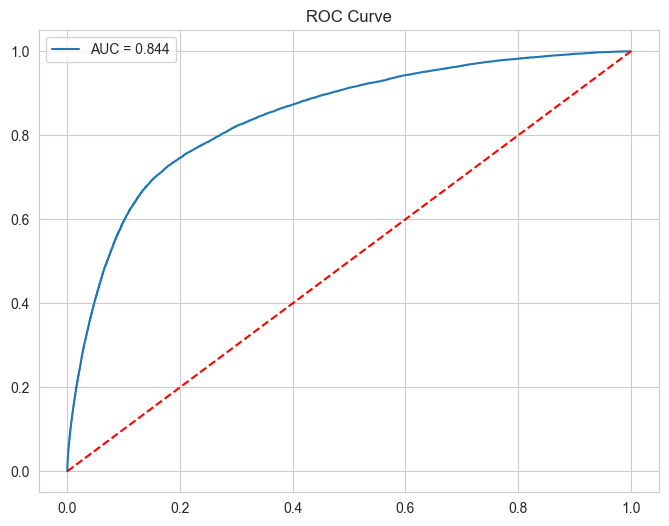

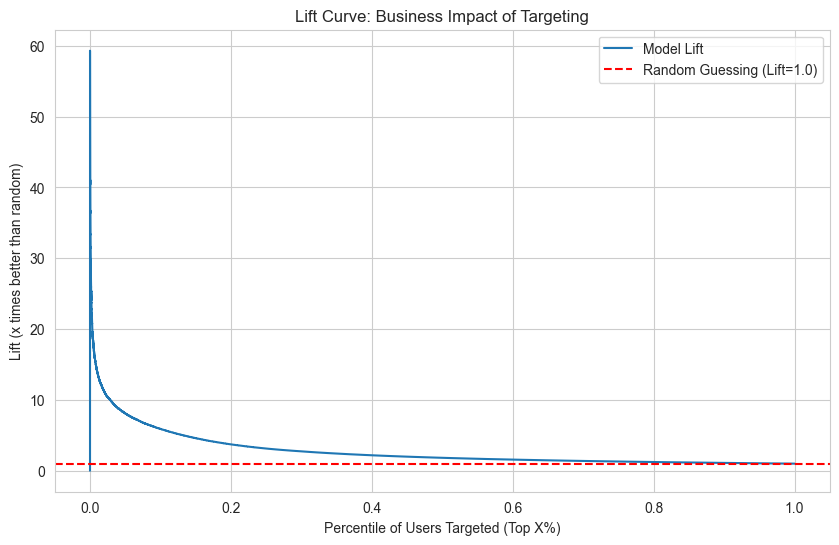

In [7]:

def plot_lift_curve(y_true, y_pred, step=0.1):
    # Create a DataFrame for analysis
    data = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    data = data.sort_values('y_pred', ascending=False)
    
    # Calculate cumulative metrics
    data['cum_users'] = np.arange(len(data)) + 1
    data['cum_pos'] = data['y_true'].cumsum()
    data['percentile'] = data['cum_users'] / len(data)
    
    # Global CTR
    global_ctr = data['y_true'].mean()
    
    # Calculate Lift at each percentile
    # Lift = (Cumulative CTR at percentile) / Global CTR
    data['cum_ctr'] = data['cum_pos'] / data['cum_users']
    data['lift'] = data['cum_ctr'] / global_ctr
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(data['percentile'], data['lift'], label='Model Lift')
    plt.axhline(1.0, color='r', linestyle='--', label='Random Guessing (Lift=1.0)')
    plt.xlabel('Percentile of Users Targeted (Top X%)')
    plt.ylabel('Lift (x times better than random)')
    plt.title('Lift Curve: Business Impact of Targeting')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return data

def evaluate_and_visualize(model, test_df, features):
    print("Evaluating Model...")
    
    X_test = test_df[features]
    y_test = test_df['is_clicked']
    y_pred = model.predict(X_test)
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # 2. Lift Curve (Business Metric)
    lift_data = plot_lift_curve(y_test, y_pred)
    
    # 3. Key Metrics for Conclusion
    top_10_lift = lift_data[lift_data['percentile'] >= 0.1].iloc[0]['lift']
    top_20_lift = lift_data[lift_data['percentile'] >= 0.2].iloc[0]['lift']
    
    return y_pred, auc, top_10_lift, top_20_lift

y_pred, auc_score, lift_10, lift_20 = evaluate_and_visualize(model, test_df, feature_names)


Generating SHAP Explanations...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


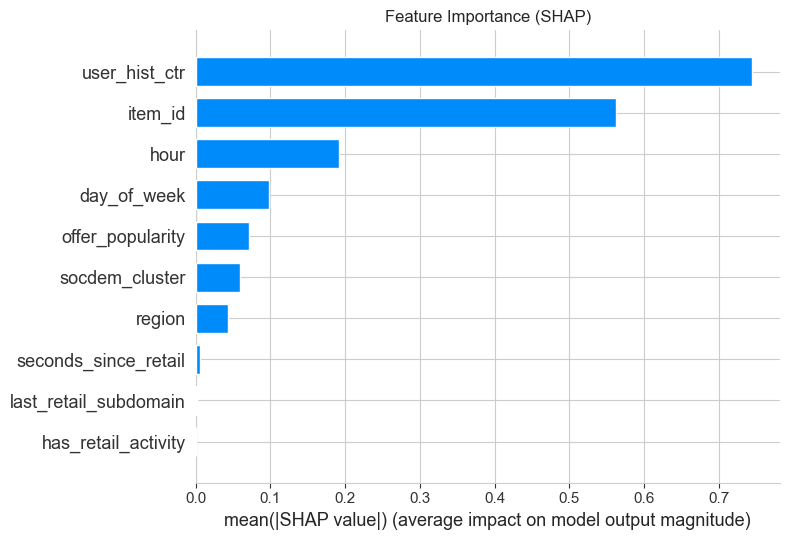

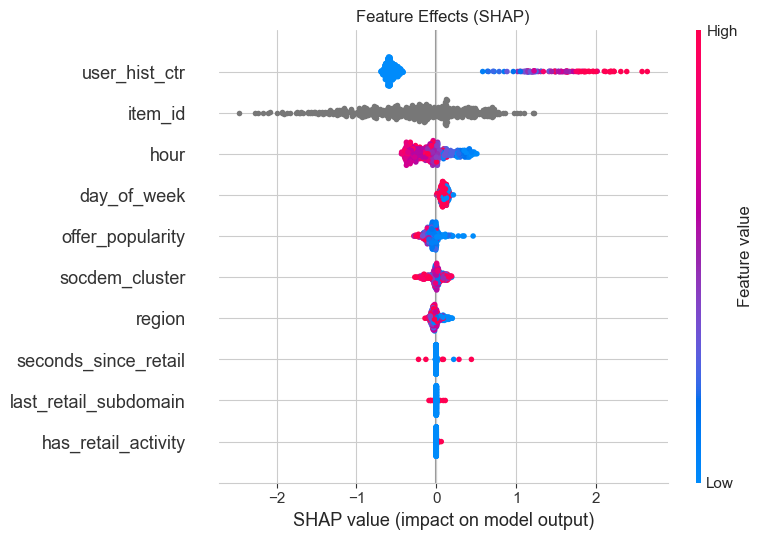

In [8]:

def explain_model(model, val_df, features):
    """
    Generate SHAP explanations for model interpretability.
    COLAB FREE: Uses small sample to avoid memory issues.
    """
    print("Generating SHAP Explanations...")
    
    # COLAB FREE: Limit sample size to prevent OOM
    sample_size = min(500, len(val_df))  # Reduced from 1000
    X_sample = val_df[features].sample(sample_size, random_state=SEED)
    
    # TreeExplainer for LightGBM (memory efficient)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # NOTE: For binary classification, shap_values behavior varies by SHAP version
    # Newer versions return single 2D array, older return list of arrays
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]  # Positive class
    else:
        shap_vals = shap_values  # Single array
    
    # Bar plot (feature importance)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_vals, X_sample, plot_type="bar", show=False)
    plt.title("Feature Importance (SHAP)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_importance.png'), dpi=100)
    plt.show()
    
    # Beeswarm plot (detailed feature effects)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_vals, X_sample, show=False)
    plt.title("Feature Effects (SHAP)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_beeswarm.png'), dpi=100)
    plt.show()
    
    # Clean up
    del X_sample, shap_values, shap_vals
    clear_memory()

explain_model(model, val_df, feature_names)


In [9]:

def print_conclusion(auc, lift_10, lift_20):
    print("="*60)
    print("FINAL CONCLUSION & BUSINESS IMPACT")
    print("="*60)
    
    print(f"1. Model Performance (AUC: {auc:.3f})")
    if auc > 0.7:
        print("   -> The model has STRONG predictive power.")
    elif auc > 0.6:
        print("   -> The model has MODERATE predictive power.")
    else:
        print("   -> The model is WEAK (close to random guessing).")
        
    print(f"\n2. Business Impact (Lift)")
    print(f"   -> Top 10% Targeting: {lift_10:.2f}x more effective than random.")
    print(f"   -> Top 20% Targeting: {lift_20:.2f}x more effective than random.")
    
    print("\n3. Verdict")
    if lift_10 > 2.0:
        print("   SUCCESS. The AI significantly outperforms random guessing.")
        print("   Recommendation: Deploy to production for A/B testing on a small traffic slice.")
    else:
        print("   UNCERTAIN. Lift is marginal.")
        print("   Recommendation: Investigate more features (e.g., item embeddings, deeper history).")

print_conclusion(auc_score, lift_10, lift_20)


FINAL CONCLUSION & BUSINESS IMPACT
1. Model Performance (AUC: 0.844)
   -> The model has STRONG predictive power.

2. Business Impact (Lift)
   -> Top 10% Targeting: 5.90x more effective than random.
   -> Top 20% Targeting: 3.72x more effective than random.

3. Verdict
   SUCCESS. The AI significantly outperforms random guessing.
   Recommendation: Deploy to production for A/B testing on a small traffic slice.


In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def select_representative_users(test_df, n_users=100):
    """
    Select 'interesting' users for the demo - not outliers.
    
    Criteria for representative users:
    1. Have at least 5 offer interactions (enough data to analyze)
    2. Have at least 1 click (so we can see what clicked looks like)
    3. Have some retail context (seconds_since_retail != -1 for at least one row)
    4. CTR between 1% and 50% (not too low, not unrealistically high)
    """
    print("Selecting representative users for demo...")
    
    # Calculate user-level stats
    user_stats = test_df.groupby('user_id').agg({
        'is_clicked': ['sum', 'count', 'mean'],
        'seconds_since_retail': lambda x: (x != -1).sum()  # Count rows with retail context
    }).reset_index()
    user_stats.columns = ['user_id', 'total_clicks', 'total_interactions', 'ctr', 'retail_context_count']
    
    # Filter for representative users
    representative = user_stats[
        (user_stats['total_interactions'] >= 5) &           # Enough interactions
        (user_stats['total_clicks'] >= 1) &                  # At least 1 click
        (user_stats['ctr'] >= 0.01) &                        # CTR >= 1%
        (user_stats['ctr'] <= 0.50)                          # CTR <= 50%
    ]
    
    # Prefer users with retail context
    with_retail = representative[representative['retail_context_count'] > 0]
    
    if len(with_retail) >= n_users:
        # Sort by CTR closest to median for most "typical" users
        median_ctr = with_retail['ctr'].median()
        with_retail = with_retail.copy()
        with_retail['ctr_distance'] = abs(with_retail['ctr'] - median_ctr)
        selected = with_retail.nsmallest(n_users, 'ctr_distance')['user_id'].tolist()
    elif len(representative) >= n_users:
        selected = representative.head(n_users)['user_id'].tolist()
    else:
        # Fallback: just get users with clicks
        has_clicks = user_stats[user_stats['total_clicks'] >= 1]
        selected = has_clicks.head(n_users)['user_id'].tolist()
    
    print(f"  Found {len(selected)} representative users")
    print(f"  Criteria: 5+ interactions, 1+ clicks, 1-50% CTR, prefer retail context")
    
    return selected

def interactive_demo(model, test_df, features):
    """
    Interactive widget to explore model predictions on test data.
    Uses REPRESENTATIVE users (not outliers) for more meaningful exploration.
    """
    print("="*60)
    print("INTERACTIVE PRODUCTION SIMULATION")
    print("="*60)
    print("Explore how the model predicts click behavior for REPRESENTATIVE users.")
    print("(Users selected to have mixed click behavior and retail context)\n")
    
    # Get representative users (not outliers)
    sample_users = select_representative_users(test_df, n_users=100)
    
    if len(sample_users) == 0:
        print("No representative users found. Falling back to first 100 users.")
        sample_users = list(test_df['user_id'].unique()[:100])
    
    if len(sample_users) == 0:
        print("No users found in test set.")
        return
    
    user_dropdown = widgets.Dropdown(
        options=sample_users,
        value=None,
        description='User ID:',
        disabled=False,
    )
    
    output = widgets.Output()
    
    def show_user_predictions(user_id):
        """Display predictions for a given user."""
        with output:
            clear_output()
            
            if user_id is None:
                return
            
            # Get User Data
            user_data = test_df[test_df['user_id'] == user_id].copy()
            
            if len(user_data) == 0:
                print("No data found for this user.")
                return
            
            # Calculate user stats
            total_clicks = user_data['is_clicked'].sum()
            total_shown = len(user_data)
            user_ctr = total_clicks / total_shown if total_shown > 0 else 0
            has_retail = (user_data['seconds_since_retail'] != -1).sum()
            
            # User Profile (Enhanced)
            print(f"--- User Profile ({user_id}) ---")
            print(f"Region: {user_data['region'].iloc[0]}")
            print(f"SocDem Cluster: {user_data['socdem_cluster'].iloc[0]}")
            print(f"Historical CTR: {user_data['user_hist_ctr'].iloc[-1]:.2%}")
            print(f"Session Stats: {total_clicks} clicks / {total_shown} offers = {user_ctr:.1%} CTR")
            print(f"Retail Context: {has_retail}/{total_shown} offers have prior retail activity")
            print("-" * 50)
            
            # Predict
            X_user = user_data[features]
            user_data['predicted_prob'] = model.predict(X_user)
            
            # Show summary of predictions vs actuals
            clicked = user_data[user_data['is_clicked'] == 1]
            ignored = user_data[user_data['is_clicked'] == 0]
            
            print(f"\n[MODEL INSIGHT]")
            if len(clicked) > 0:
                print(f"  Avg prediction for CLICKED offers: {clicked['predicted_prob'].mean():.1%}")
            if len(ignored) > 0:
                print(f"  Avg prediction for IGNORED offers: {ignored['predicted_prob'].mean():.1%}")
            if len(clicked) > 0 and len(ignored) > 0:
                lift = clicked['predicted_prob'].mean() / ignored['predicted_prob'].mean()
                print(f"  Model Separation: {lift:.2f}x (clicked vs ignored)")
            
            # Format for Display
            display_cols = [
                'timestamp', 'item_id', 'offer_popularity',
                'hour', 'last_retail_subdomain', 
                'seconds_since_retail', 'is_clicked', 'predicted_prob'
            ]
            
            display_cols = [c for c in display_cols if c in user_data.columns]
            
            display_df = user_data[display_cols].copy()
            display_df['is_clicked'] = display_df['is_clicked'].map({1: 'CLICKED', 0: 'Ignored'})
            display_df['predicted_prob'] = display_df['predicted_prob'].map('{:.1%}'.format)
            
            if 'seconds_since_retail' in display_df.columns:
                display_df['seconds_since_retail'] = display_df['seconds_since_retail'].apply(
                    lambda x: f"{x:.0f}s" if x != -1 else "N/A"
                )
            if 'offer_popularity' in display_df.columns:
                display_df['offer_popularity'] = display_df['offer_popularity'].astype(int)
            
            print(f"\nRecent Offer Interactions ({len(display_df)}):")
            display(display_df)
    
    def on_user_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            show_user_predictions(change['new'])
    
    user_dropdown.observe(on_user_change)
    display(user_dropdown, output)
    
    # Trigger initial load
    user_dropdown.value = sample_users[0]

interactive_demo(model, test_df, feature_names)


INTERACTIVE PRODUCTION SIMULATION
Explore how the model predicts click behavior for REPRESENTATIVE users.
(Users selected to have mixed click behavior and retail context)

Selecting representative users for demo...
  Found 100 representative users
  Criteria: 5+ interactions, 1+ clicks, 1-50% CTR, prefer retail context


Dropdown(description='User ID:', options=(38349452, 40574324, 5285187, 45856780, 86056221, 56599703, 83144983,…

Output()